## **Lab 6. Vision Transformer**

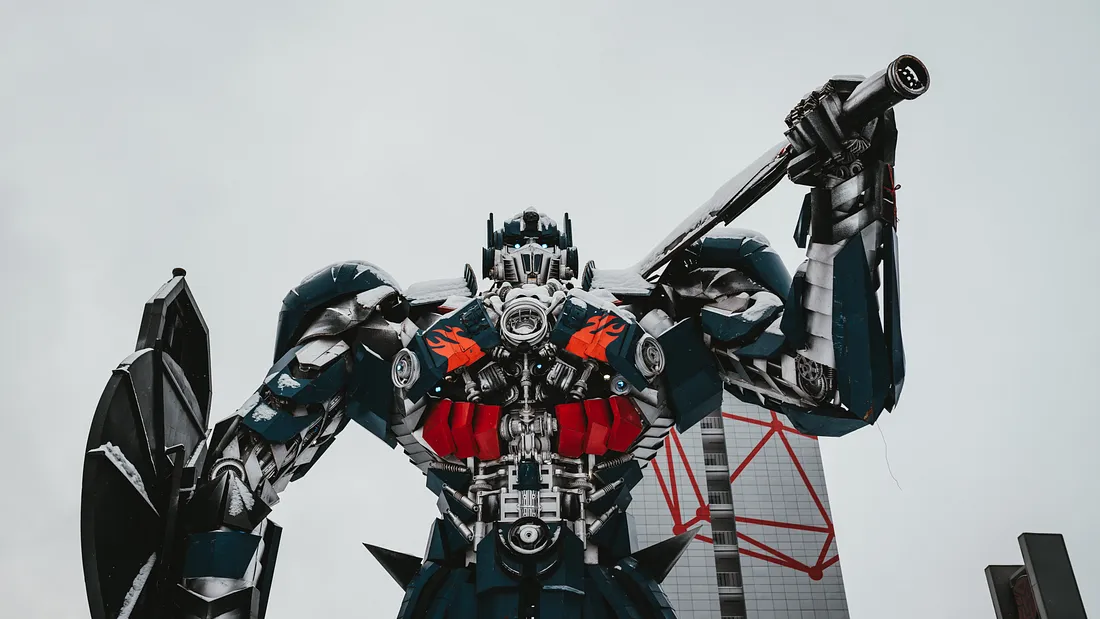

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2 
import tqdm

import torch, torchvision
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

## Data preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root=r'D:\DataScience\ONU\datasets\cifar10', 
                                        train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root=r'D:\DataScience\ONU\datasets\cifar10', 
                                       train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=4)

test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Some images from a random batch

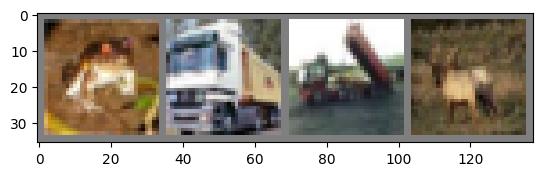

frog  truck truck deer 


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [4]:
print(f'Number of train batches: {len(train_loader)}')
print(f'Number of test  batches: {len(test_loader)}')
print(f'Total number of batches: {len(train_loader) + len(test_loader)}')

Number of train batches: 391
Number of test  batches: 79
Total number of batches: 470


### Setting up the device

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# **Part 1. Building ResNet20 for image tokenization**

## **1. Implementing ResNet block**

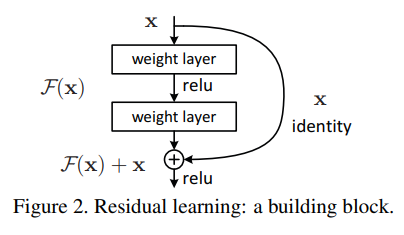

#### From paper https://arxiv.org/pdf/1512.03385 (page 4)

_"_

---

_We adopt batch normalization (BN) [16] right after each 
convolution and before activation, following [16]._

_We initialize the weights as in [13] and train all plain/residual nets from scratch. We
use SGD with a mini-batch size of 256._

_The learning rate starts from 0.1 and is divided by 10 when the error 
plateaus, and the models are trained for up to 60 × 104 iterations._

_We use a weight decay of 0.0001 and a momentum of 0.9. 
We do not use dropout [14], following the practice in [16]._

---

_When the dimensions increase (dotted line shortcuts in Fig. 3), we consider two options:_

_(A) The shortcut still performs identity mapping, with extra zero entries padded
for increasing dimensions. This option introduces no extra parameter;_ 

_(B) The projection shortcut in Eqn.(2) is used to
match dimensions (done by 1×1 convolutions)._ 

_For both options, when the shortcuts go across feature maps of 
two sizes, they are performed with a stride of 2._

---

_"_

In [6]:
class ResNetBlock(nn.Module):
    """
    Implements ResNet block for models with num < 50
    (resnet10, resnet18, resnet20, ... etc)

    'last_relu' parameter may disappear
    """
    def __init__(self, in_channels, out_channels, conv1_stride=1):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=3, padding=1, stride=conv1_stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 
                      kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        self.conv_1x1 = nn.Sequential()
        if in_channels != out_channels:
            self.conv_1x1 = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=2, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        """
        ReLU(F(x) + x)
        """
        relu = nn.ReLU()
        output = self.block(x)

        return relu(output + self.conv_1x1(x))

## **2. Implementing ResNet layer**

#### First layer
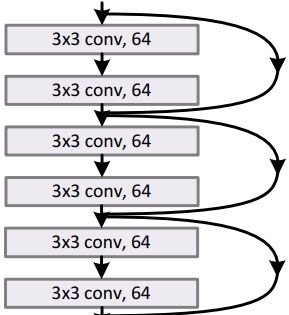

#### Every other layer (with channels increasing)
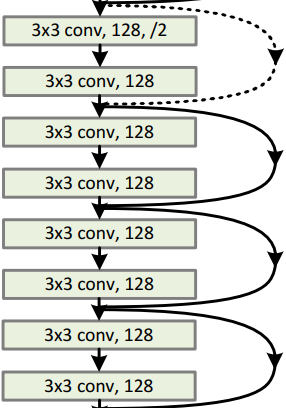

In [7]:
class ResNetLayer(nn.Module):
    """
    Implements ResNet layer
    The layer consists of multiple ResNet blocks
    """
    def __init__(self, in_channels, out_channels, layer_dim=2, first_downsample=False):
        super().__init__()
        self.layer = nn.Sequential()
        
        # Downsampling input to the current layer
        if first_downsample:
            self.layer.append(ResNetBlock(in_channels, out_channels, conv1_stride=2))

        # Adding the rest of the blocks to the layer
        for i in range(len(self.layer), layer_dim):
            self.layer.append(ResNetBlock(out_channels, out_channels))
            # print(in_channels, out_channels)

    def forward(self, x):
        return self.layer(x)

## **3. Implementing ResNet model**

#### ResNet architecture for CIFAR10 dataset

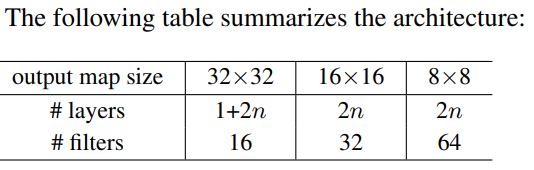

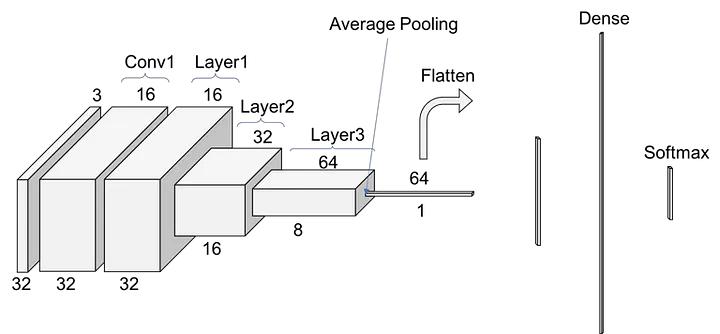

In [326]:
class ResNet(nn.Module):
    """
    Implements Residual Network (ResNet) without average pooling and fully-connected layer
    The basic model for CIFAR10 dataset is resnet20
    """
    def __init__(self, in_channels, num_classes = 10, 
                 layer_dims:list = [3, 3, 3], initial_channels = 16, trimmed=True):
        super().__init__()

        self.trimmed = trimmed
        if not self.trimmed:
            output_size = initial_channels * 2**(len(layer_dims)-1)
            self.fc_layer = nn.Linear(output_size, num_classes)
        
        # ---------- First convolution (and maxpool for ImageNet) ---------
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=initial_channels, 
                      kernel_size=3, stride=1, padding=1, bias=False),  # Change stride to 2 and padding to 3 if used on ImageNet
            nn.BatchNorm2d(initial_channels),
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=0),         # Uncomment if used on ImageNet
        )

        # ------------------------- ResNet layers -------------------------
        # Size of the first block of each layer: (16, 16)  -->  (16, 32)  -->  (32, 64)
        
        self.net.append(
            ResNetLayer(in_channels=initial_channels, 
                        out_channels=initial_channels, 
                        layer_dim=layer_dims[0])
        )
        
        in_channels = initial_channels
        out_channels = in_channels * 2

        for dim in layer_dims[1:]:
            self.net.append(
                ResNetLayer(in_channels, out_channels,
                            layer_dim=dim, first_downsample=True)
            )
            in_channels *= 2
            out_channels *= 2


    def forward(self, x):
        """
        Creates a final feature map
        """
        output = self.net(x)

        if not self.trimmed:
            avg_pool = nn.AvgPool2d(kernel_size=output.shape[3])
            output = avg_pool(output)
            output = output.view(output.size(0), -1)
            output = self.fc_layer(output)
        
        return output

### Creating pretrained resnet20 instance for image patchifying

In [9]:
# My pretrained on cifar10 resnet20
resnet20 = ResNet(in_channels=3, num_classes=10, layer_dims=[3, 3, 3], initial_channels=16)
print(resnet20)

ResNet(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ResNetLayer(
      (layer): Sequential(
        (0): ResNetBlock(
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (conv_1x1): Sequential()
        )
        (1): ResNetBlock(
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, tr

In [10]:
# Importing model`s learned parameters
path = r'D:\DataScience\ONU\completed_labs\Pretrained_models'  # add a '\' at the end of the path
state_dict = torch.load(path+'my_resnet20')

In [11]:
# Deleting fully-connected layer parameters from state_dict
del state_dict['fc_layer.weight']
del state_dict['fc_layer.bias']

In [234]:
resnet20.load_state_dict(state_dict)
resnet20 = resnet20.to('cpu')
resnet20.eval()

ResNet(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ResNetLayer(
      (layer): Sequential(
        (0): ResNetBlock(
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (conv_1x1): Sequential()
        )
        (1): ResNetBlock(
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, tr

# **Part 2. Building Vision Transformer**

## **1. Implementing filter-based tokenization**
#### From paper: https://arxiv.org/pdf/2006.03677

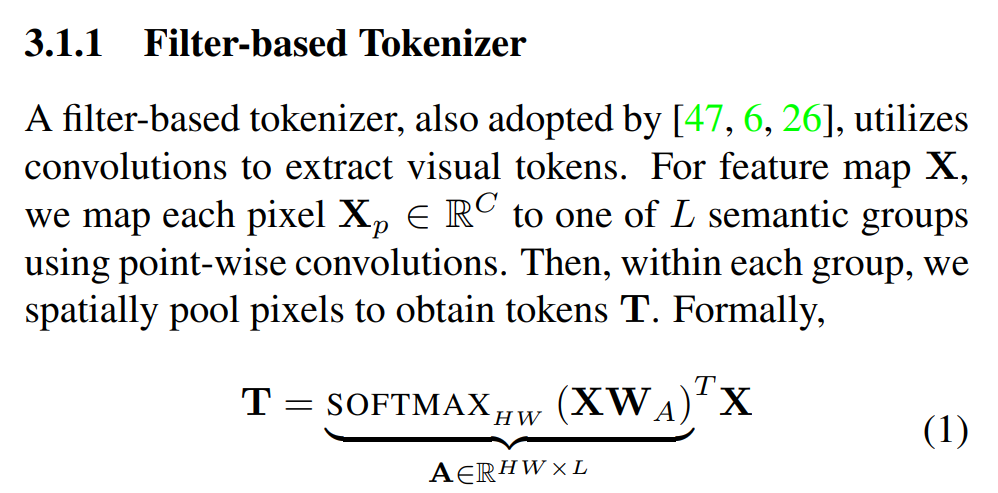
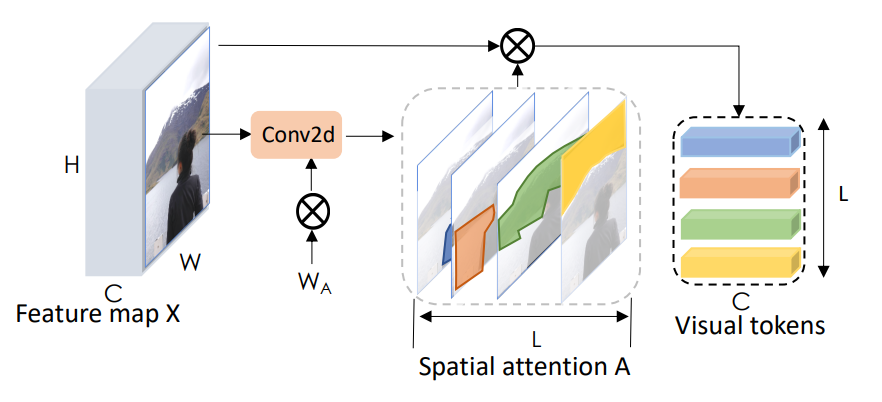

In [239]:
class Tokenizer(nn.Module):
    """
    Filter-based tokenizer.
    Properties:
        n_tokens == n_channels  of the given feature map
        token_size == H x W,  where H, W are the dimensions of the feature map
        output.shape:  B  x  n_tokens  x  token_size
    """
    def __init__(self):
        super().__init__()
        # Prediction token
        
        # self.W_A = 
        # I will use a simpler tokenizer with possibility to change it later, as mentioned in the paper above 
    
    def forward(self, feature_map):
        tokens = feature_map.flatten(start_dim=2)
        device = tokens.device
        
        # Adding prediction token to tokens
        batch_size, num_tokens, token_size = tokens.shape
        pred_token = torch.zeros(1, 1, token_size).expand(batch_size, -1, -1).to(device)
        tokens = torch.cat((pred_token, tokens), dim=1)
        
        return tokens

#### Dimensionality check

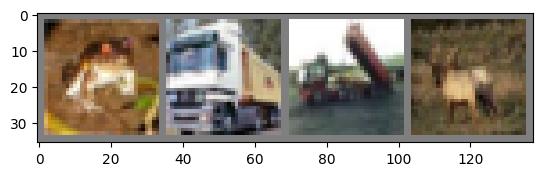

In [240]:
imshow(torchvision.utils.make_grid(images[:4]))

In [241]:
# Should produce 4 batches, each with the last 64-channel feature map of resnet20 of size 8x8
output = resnet20(images[:4])
print(output.shape)

torch.Size([4, 64, 8, 8])


In [242]:
# Should produce 4 batches, each with 65 tokens of length 64 (including prediction token)
tokenizer = Tokenizer()
tokens = tokenizer(output)
print(tokens.shape)

torch.Size([4, 65, 64])


## **2. Implementing Position Embedding (PE) block**

The dominant approach for preserving information about the order of tokens is to represent this to the model as an additional input associated with each token. These inputs are called positional encodings, and they can either be learned or fixed a priori. We now describe a simple scheme for fixed positional encodings based on sine and cosine functions (Vaswani et al., 2017).

Suppose that the input representation $X \in \mathbb{R}^{n\times d}$
 contains the 
d-dimensional embeddings for 
 tokens of a sequence. The positional encoding outputs $X + P$
 using a positional embedding matrix $P$
 of the same shape, whose element on the 
 i-th row and the 2j
 or the 2j+1  
 column is
 $$ p_{i, 2j} = \sin \frac{i}{10000^{2j/d}} $$
 $$ p_{i, 2j+1} = \cos \frac{i}{10000^{2j+1/d}} $$

 where $i$ is the token index, $j$ ranges in $[0; d]$, and $d$ is the token size.

In [262]:
class PositionalEmbedding(nn.Module):
    """
    Implenets positional embedding for tokens using sine and cosine functions
    """
    def __init__(self, num_tokens=65, token_size=64):
        super().__init__()
        self.P = torch.zeros((1, num_tokens, token_size))
        sincos_table = torch.arange(num_tokens, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, token_size, 2, dtype=torch.float32)/token_size)
        self.P[:, :, 0::2] = torch.sin(sincos_table)
        self.P[:, :, 1::2] = torch.cos(sincos_table)

    def forward(self, X):
        device = X.device
        self.P = self.P.to(device)
        
        X = X + self.P
        return X

#### Dimensionality check

In [263]:
print(tokens.shape)

torch.Size([4, 65, 64])


In [264]:
PE = PositionalEmbedding(num_tokens=64+1, token_size=64)
tokens_encoded = PE(tokens)
print(tokens_encoded.shape)

torch.Size([4, 65, 64])


## **3. Implementing Multi-Head Attention for ViT**
Images from: 

https://towardsdatascience.com/attention-for-vision-transformers-explained-70f83984c673

https://arxiv.org/pdf/1904.09925

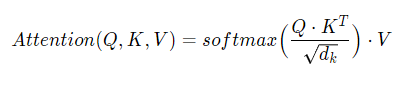

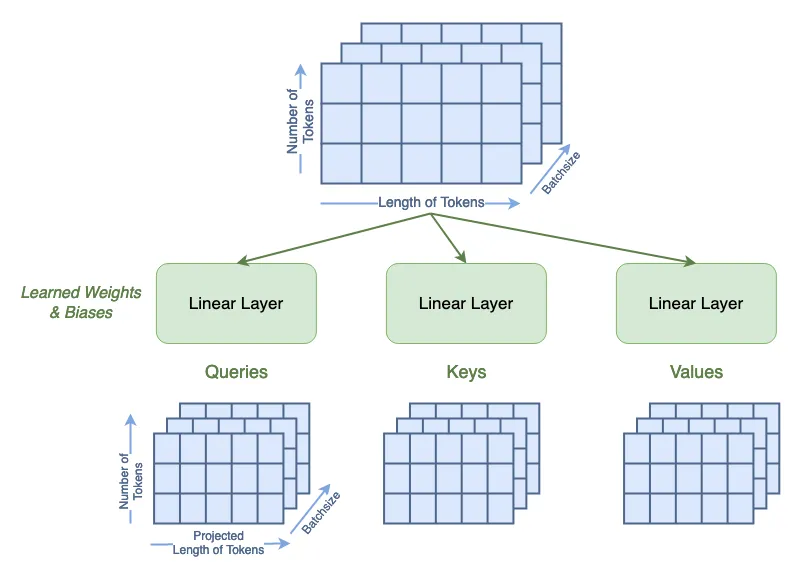

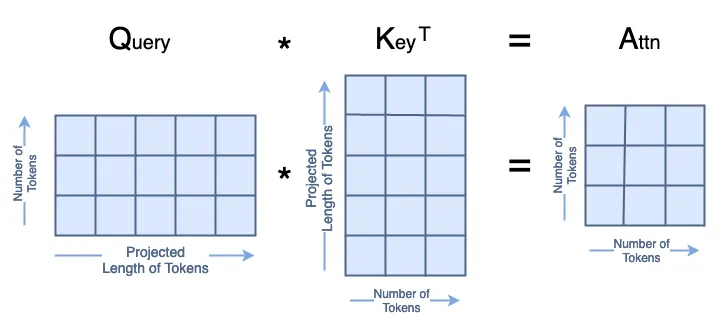

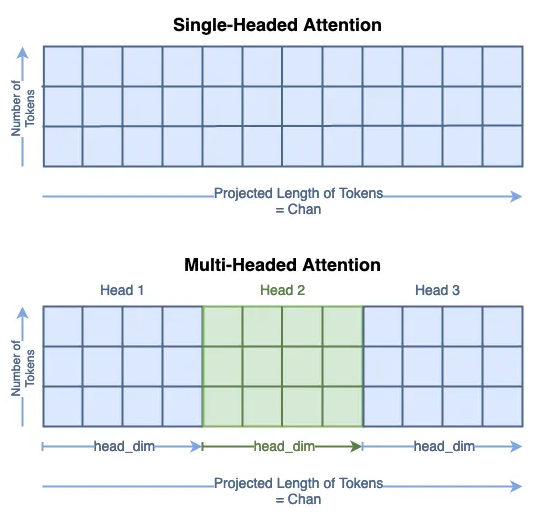

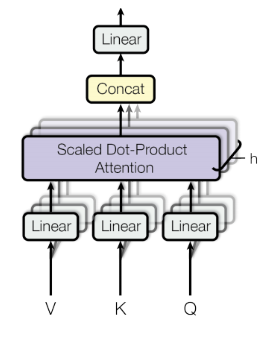

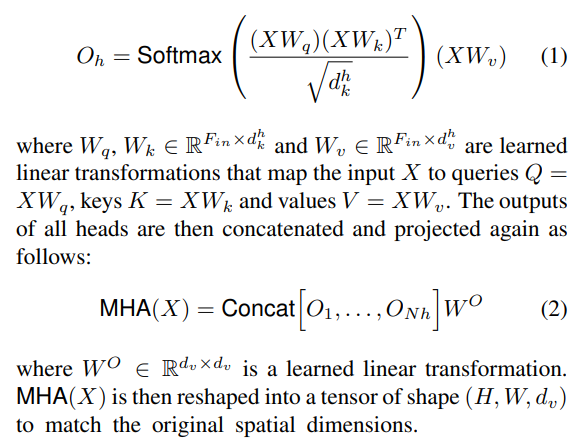

In [265]:
class MultiHeadAttention(nn.Module):
    """
    Implements multihead attention for embedded tokens
    """
    def __init__(self, token_size=64, num_heads=4):
        """
        Defined parameters:
            token_size - the length of a single token
            num_heads - the number of self-attention heads
            head_size - the size of a single head (token_size / num_heads)
        """
        super().__init__()
        self.token_size = token_size
        self.num_heads = num_heads
        
        assert token_size % num_heads == 0  # token_size should be divisible by num_heads
        self.head_size = token_size // num_heads
        
        self.W_q = nn.Linear(self.token_size, self.token_size)  # queries` weights
        self.W_k = nn.Linear(self.token_size, self.token_size)  # keys` weights
        self.W_v = nn.Linear(self.token_size, self.token_size)  # values` weights
        self.W_output = nn.Linear(self.token_size, self.token_size)

    def forward(self, X):
        """
        I have skill issues with implementing MHA using separate functions and classes
        """
        batch_size, num_tokens, token_size = X.shape

        # Applying Q, K, V transformations
        Q = self.W_q(X)  # (batch_size, num_tokens, token_size)
        K = self.W_k(X)  # (batch_size, num_tokens, token_size)
        V = self.W_v(X)  # (batch_size, num_tokens, token_size)

        # Splitting Q, K, V into multiple heads
        Q = Q.view(batch_size, num_tokens, self.num_heads, self.head_size)
        K = K.view(batch_size, num_tokens, self.num_heads, self.head_size)
        V = V.view(batch_size, num_tokens, self.num_heads, self.head_size)

        # Transpose to get dimensions (batch_size, num_heads, num_tokens, head_size)
        Q = Q.permute(0, 2, 1, 3)
        K = K.permute(0, 2, 1, 3)
        V = V.permute(0, 2, 1, 3)

        # Calculating attention scores with dimensions (batch_size, num_heads, num_tokens, num_tokens)
        # scores = torch.matmul(Q, K.transpose(-1, -2))  # should be a square matrix for each head (num_tokens, num_tokens)
        scores = Q @ K.transpose(-1, -2)

        # Getting attention weights using softmax  (batch_size, num_heads, num_tokens, num_tokens)
        attention = torch.softmax(scores / np.sqrt(self.head_size), dim=-1)

        # Calculating outputs
        # output = torch.matmul(attention, V)  # (batch_size, num_heads, num_tokens, head_size)
        output = attention @ V

        # Reshape to (batch_size, num_tokens, token_size)
        output = output.permute(0, 2, 1, 3).contiguous()
        output = output.view(batch_size, num_tokens, self.num_heads * self.head_size)

        # Final linear projection  (batch_size, num_tokens, token_size)
        output = self.W_output(output)
        return output

#### Dimensionality check

In [266]:
print(tokens_encoded.shape)

torch.Size([4, 65, 64])


In [267]:
MHA = MultiHeadAttention(token_size=64, num_heads=4)
output = MHA(tokens_encoded)
print(output.shape)

torch.Size([4, 65, 64])


## **4. Implementing Transformer Encoder**

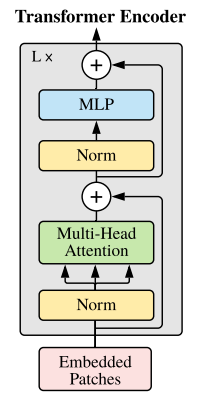

### **4.1 Implementing Encoder Block**

In [268]:
class FFN(nn.Module):
    """
    Implements feed-forward network (small MLP by default for ViT)
    """
    def __init__(self, ffn_dim, token_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(ffn_dim, token_size),
            nn.ReLU(),
            nn.Linear(token_size, token_size)
        )
        
    def forward(self, X):
        return self.net(X)

In [269]:
class EncoderBlock(nn.Module):
    """
    Implenets transformer encoder block
    """
    def __init__(self, token_size=64, ffn_dim=64, num_heads=4):
        """
        Defined parameters:
            token_size - the length of a single token
            ffn_dim - the dimension of an input to the feed-forward network (FFN)
            num_heads - the number of self-attention heads
            norm - layer normalization
            attention - multi-head attention block
            ffn - feed-forward network
        """
        super().__init__()
        self.token_size = token_size
        self.ffn_dim = ffn_dim
        self.num_heads = num_heads

        self.norm = nn.LayerNorm(token_size)
        # self.addnorm = AddNorm(token_size)
        self.attention = MultiHeadAttention(token_size, num_heads)
        self.ffn = FFN(ffn_dim, token_size)

    def forward(self, X):
        output = self.attention(self.norm(X)) + X
        output = self.ffn(self.norm(output)) + output
        return output

### **4.2 Implementing Transformer Encoder**

In [270]:
class Encoder(nn.Module):
    """
    Implements full transformer encoder (with multiple encoder blocks)
    """
    def __init__(self, token_size=64, ffn_dim=64, num_heads=4, num_blocks=2):
        """
        Defined parameters:
            token_size - the length of a single token
            ffn_dim - the dimension of an input to the feed-forward network (FFN)
            num_heads - the number of self-attention heads
            norm - layer normalization
            attention - multi-head attention block
            ffn - feed-forward network
            num_blocks - the number of encoder blocks
        """
        super().__init__()
        self.encoder = nn.Sequential()
        
        for i in range(num_blocks):
            self.encoder.append(
                EncoderBlock(token_size, ffn_dim, num_heads)
            )

    def forward(self, X):
        return self.encoder(X)

#### Dimensionality check

In [271]:
encoder = Encoder(token_size=64, ffn_dim=64, num_heads=4, num_blocks=3)
print(encoder)

Encoder(
  (encoder): Sequential(
    (0): EncoderBlock(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=True)
        (W_k): Linear(in_features=64, out_features=64, bias=True)
        (W_v): Linear(in_features=64, out_features=64, bias=True)
        (W_output): Linear(in_features=64, out_features=64, bias=True)
      )
      (ffn): FFN(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
        )
      )
    )
    (1): EncoderBlock(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=True)
        (W_k): Linear(in_features=64, out_features=64, bias=True)
        (W_v): Linear(in_features=64, out_features=64, bias=True)
        (W

In [272]:
print(tokens_encoded.shape)

torch.Size([4, 65, 64])


In [273]:
output = encoder(tokens_encoded)
print(output.shape)

torch.Size([4, 65, 64])


## **5. Implementing Vision Transformer (ViT)**

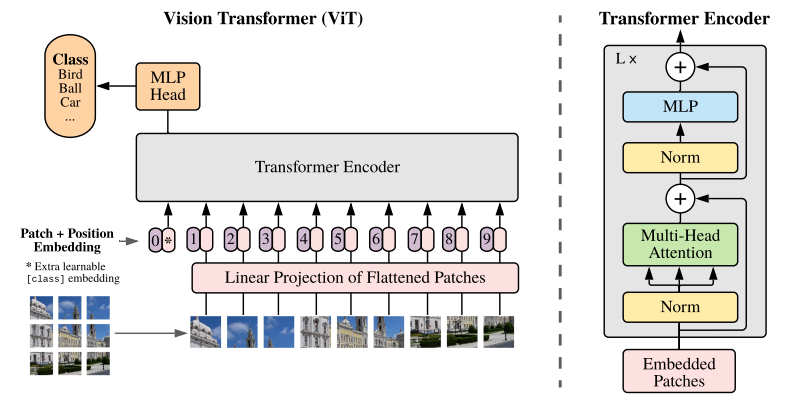

#### We are going to implement the following architecture with a few exceptions:
- Tokenization process will be simplified (we won't use spatial attention for our task);
- Instead of projector, we are going to use MLP classifier (as in basic ViT on the image above).


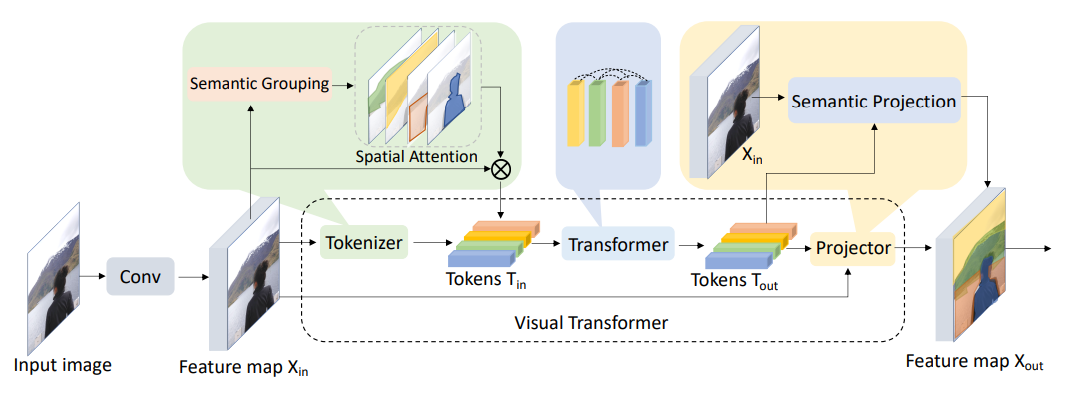

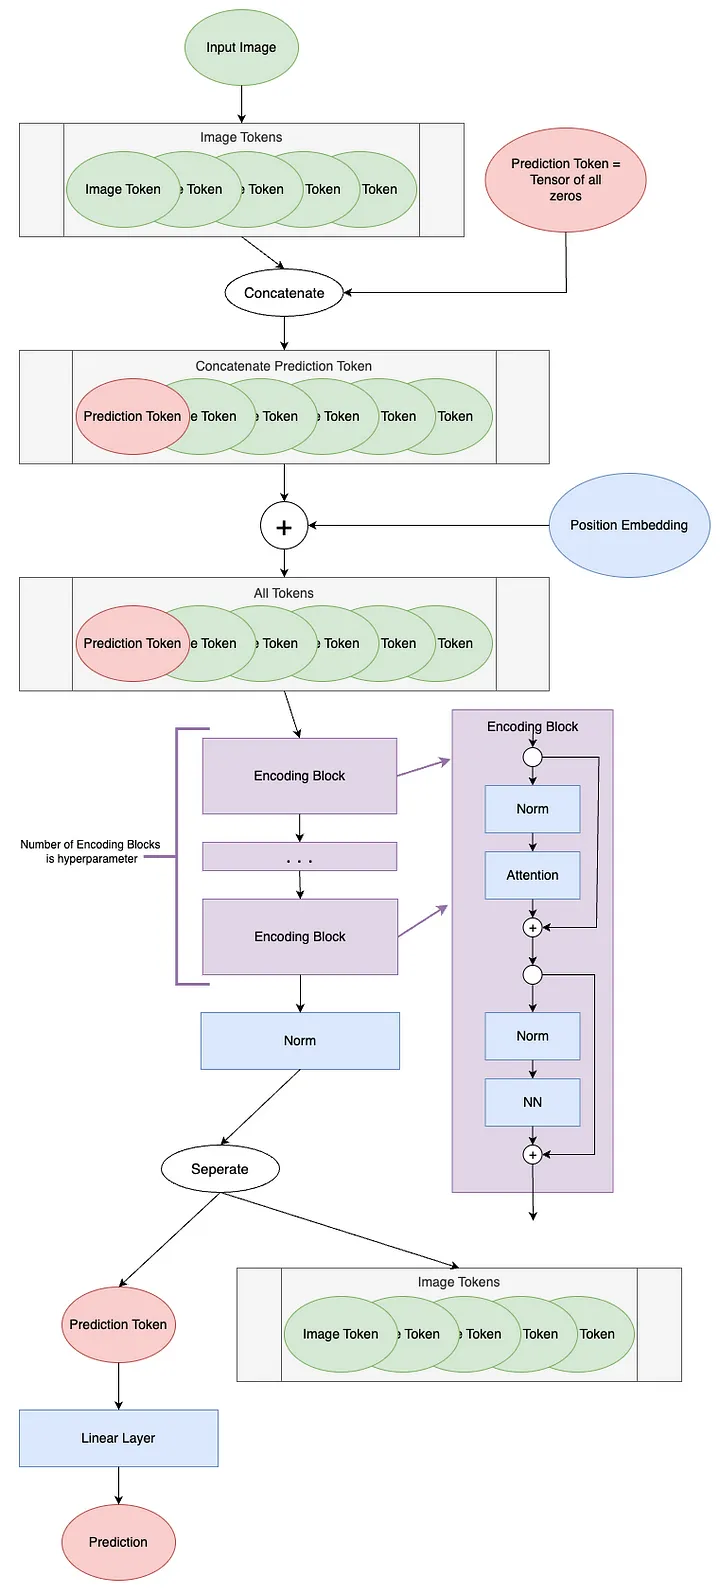

In [274]:
class ClassificationHead(nn.Module):
    """
    Implements classification head for ViT
    """
    def __init__(self, token_size=64, num_classes=10):
        super().__init__()
        self.net = nn.Linear(token_size, num_classes)

    def forward(self, X):
        return self.net(X[:, 0])

In [299]:
class VisionTransformer(nn.Module):
    """
    Implements Vision Transformer, combined with ResNet
    """
    def __init__(self, num_tokens=64+1, token_size=64, ffn_dim=64, num_heads=4, num_blocks=2, resnet=None, num_classes=10):
        """
        Arguments:
            token_size - the length of a single token
            ffn_dim - the dimension of an input to the feed-forward network (FFN)
            num_heads - the number of self-attention heads
            num_blocks - the number of encoder blocks
            resnet - the specified pretrained ResNet without the fc-layer
        """
        super().__init__()

        assert type(resnet) == ResNet
        self.resnet = resnet
        self.resnet.eval()
        
        self.transformer = nn.Sequential(
            Tokenizer(),
            PositionalEmbedding(num_tokens, token_size),
            Encoder(token_size, ffn_dim, num_heads, num_blocks),
            ClassificationHead(token_size, num_classes)
        )

    def forward(self, X):
        # Freezing ResNet parameters
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        with torch.no_grad():  # Ensure ResNet is in inference mode
            feature_map = self.resnet(X)
        output = self.transformer(feature_map)
        return output

#### Dimensionality check

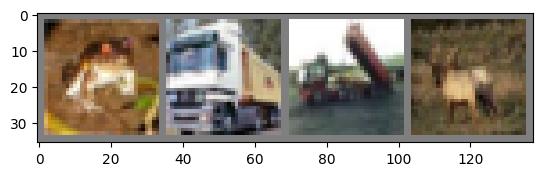

In [300]:
imshow(torchvision.utils.make_grid(images[:4]))

In [301]:
model = VisionTransformer(token_size=64, ffn_dim=64, num_heads=4, num_blocks=3, resnet=resnet20, num_classes=10)

In [302]:
model = model.to(device)

In [303]:
output = model(images[:4].to(device))
print(output.shape)

torch.Size([4, 10])


## **Training loop**

In [304]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [305]:
# Switching model to training mode
model.train()

n_epochs = 5
n_batches = len(train_loader)
epoch_loss = []

for epoch in tqdm.tqdm(range(n_epochs)):
    # Accumulated loss above all batches
    running_loss = 0.0
    
    for i, data in tqdm.tqdm(enumerate(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # switching to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # inputs = torch.nn.functional.interpolate(inputs, (227, 227))
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:    # print every 100 batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            # epoch_loss.append(running_loss / 100)
            running_loss = 0.0

    # Saving average loss above all batches
    epoch_loss.append(running_loss / n_batches)

# Switching model to evaluation mode
model.eval()

print('Finished Training')

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.25it/s]
2it [00:00,  2.24it/s]
5it [00:01,  6.46it/s]
8it [00:01, 10.68it/s]
12it [00:01, 15.82it/s]
15it [00:01, 18.70it/s]
19it [00:01, 22.41it/s]
23it [00:01, 25.09it/s]
27it [00:01, 27.15it/s]
31it [00:01, 28.66it/s]
35it [00:02, 29.67it/s]
39it [00:02, 30.31it/s]
43it [00:02, 30.84it/s]
47it [00:02, 31.28it/s]
51it [00:02, 31.60it/s]
55it [00:02, 31.82it/s]
59it [00:02, 32.06it/s]
63it [00:02, 31.82it/s]
67it [00:03, 31.90it/s]
71it [00:03, 32.03it/s]
75it [00:03, 32.20it/s]
79it [00:03, 32.09it/s]
83it [00:03, 32.17it/s]
87it [00:03, 32.09it/s]
91it [00:03, 32.16it/s]
95it [00:03, 32.17it/s]
99it [00:04, 32.22it/s]
103it [00:04, 32.10it/s]

[1,   100] loss: 1.670



107it [00:04, 32.10it/s]
111it [00:04, 32.17it/s]
115it [00:04, 32.30it/s]
119it [00:04, 32.39it/s]
123it [00:04, 32.46it/s]
127it [00:04, 32.50it/s]
131it [00:05, 32.61it/s]
135it [00:05, 32.60it/s]
139it [00:05, 32.60it/s]
143it [00:05, 32.53it/s]
147it [00:05, 32.63it/s]
151it [00:05, 32.55it/s]
155it [00:05, 32.64it/s]
159it [00:05, 32.40it/s]
163it [00:06, 32.22it/s]
167it [00:06, 32.26it/s]
171it [00:06, 32.39it/s]
175it [00:06, 32.45it/s]
179it [00:06, 32.42it/s]
183it [00:06, 32.48it/s]
187it [00:06, 32.44it/s]
191it [00:06, 32.41it/s]
195it [00:07, 32.31it/s]
199it [00:07, 32.40it/s]
203it [00:07, 32.39it/s]

[1,   200] loss: 0.948



207it [00:07, 32.45it/s]
211it [00:07, 32.42it/s]
215it [00:07, 32.32it/s]
219it [00:07, 32.32it/s]
223it [00:07, 32.41it/s]
227it [00:08, 32.47it/s]
231it [00:08, 32.43it/s]
235it [00:08, 32.48it/s]
239it [00:08, 32.52it/s]
243it [00:08, 32.47it/s]
247it [00:08, 32.51it/s]
251it [00:08, 32.46it/s]
255it [00:08, 32.42it/s]
259it [00:08, 32.48it/s]
263it [00:09, 32.40it/s]
267it [00:09, 32.46it/s]
271it [00:09, 32.46it/s]
275it [00:09, 32.50it/s]
279it [00:09, 32.46it/s]
283it [00:09, 32.50it/s]
287it [00:09, 32.45it/s]
291it [00:09, 32.58it/s]
295it [00:10, 32.51it/s]
299it [00:10, 32.54it/s]
303it [00:10, 32.48it/s]

[1,   300] loss: 0.784



307it [00:10, 32.44it/s]
311it [00:10, 32.49it/s]
315it [00:10, 32.52it/s]
319it [00:10, 32.55it/s]
323it [00:10, 32.49it/s]
327it [00:11, 32.45it/s]
331it [00:11, 32.34it/s]
335it [00:11, 32.34it/s]
339it [00:11, 32.34it/s]
343it [00:11, 32.34it/s]
347it [00:11, 32.19it/s]
351it [00:11, 32.23it/s]
355it [00:11, 32.22it/s]
359it [00:12, 32.26it/s]
363it [00:12, 31.82it/s]
367it [00:12, 31.98it/s]
371it [00:12, 32.16it/s]
375it [00:12, 32.30it/s]
379it [00:12, 32.39it/s]
383it [00:12, 32.37it/s]
387it [00:12, 32.52it/s]
391it [00:14, 27.31it/s]
 20%|████████████████▊                                                                   | 1/5 [00:30<02:00, 30.15s/it]
0it [00:00, ?it/s]
1it [00:00,  5.02it/s]
4it [00:00, 15.07it/s]
7it [00:00, 20.14it/s]
10it [00:00, 23.37it/s]
14it [00:00, 26.48it/s]
18it [00:00, 28.28it/s]
22it [00:00, 29.46it/s]
26it [00:01, 30.30it/s]
30it [00:01, 30.78it/s]
34it [00:01, 31.03it/s]
38it [00:01, 31.05it/s]
42it [00:01, 30.92it/s]
46it [00:01, 30.90it/s]
5

[2,   100] loss: 0.671



106it [00:03, 31.93it/s]
110it [00:03, 31.90it/s]
114it [00:03, 32.04it/s]
118it [00:03, 32.13it/s]
122it [00:04, 32.12it/s]
126it [00:04, 32.27it/s]
130it [00:04, 32.30it/s]
134it [00:04, 32.39it/s]
138it [00:04, 32.38it/s]
142it [00:04, 32.40it/s]
146it [00:04, 32.27it/s]
150it [00:04, 32.29it/s]
154it [00:05, 32.31it/s]
158it [00:05, 32.40it/s]
162it [00:05, 32.38it/s]
166it [00:05, 32.45it/s]
170it [00:05, 32.50it/s]
174it [00:05, 32.53it/s]
178it [00:05, 32.47it/s]
182it [00:05, 32.51it/s]
186it [00:06, 32.54it/s]
190it [00:06, 32.48it/s]
194it [00:06, 32.44it/s]
198it [00:06, 32.49it/s]
202it [00:06, 32.45it/s]


[2,   200] loss: 0.649


206it [00:06, 32.50it/s]
210it [00:06, 32.45it/s]
214it [00:06, 32.49it/s]
218it [00:07, 32.45it/s]
222it [00:07, 32.47it/s]
226it [00:07, 32.51it/s]
230it [00:07, 32.38it/s]
234it [00:07, 32.37it/s]
238it [00:07, 32.36it/s]
242it [00:07, 32.44it/s]
246it [00:07, 32.41it/s]
250it [00:08, 32.39it/s]
254it [00:08, 32.45it/s]
258it [00:08, 32.42it/s]
262it [00:08, 32.40it/s]
266it [00:08, 32.46it/s]
270it [00:08, 32.42it/s]
274it [00:08, 32.48it/s]
278it [00:08, 32.44it/s]
282it [00:08, 32.49it/s]
286it [00:09, 32.52it/s]
290it [00:09, 32.47it/s]
294it [00:09, 32.42it/s]
298it [00:09, 32.45it/s]
302it [00:09, 32.39it/s]


[2,   300] loss: 0.624


306it [00:09, 32.46it/s]
310it [00:09, 32.42it/s]
314it [00:09, 32.40it/s]
318it [00:10, 32.38it/s]
322it [00:10, 32.37it/s]
326it [00:10, 32.05it/s]
330it [00:10, 31.76it/s]
334it [00:10, 31.86it/s]
338it [00:10, 31.62it/s]
342it [00:10, 31.42it/s]
346it [00:10, 31.69it/s]
350it [00:11, 31.58it/s]
354it [00:11, 31.36it/s]
358it [00:11, 31.14it/s]
362it [00:11, 31.05it/s]
366it [00:11, 31.49it/s]
370it [00:11, 30.72it/s]
374it [00:11, 30.21it/s]
378it [00:12, 29.46it/s]
381it [00:12, 28.13it/s]
384it [00:12, 27.85it/s]
387it [00:12, 28.35it/s]
391it [00:13, 29.25it/s]
 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.20s/it]
0it [00:00, ?it/s]
3it [00:00, 25.06it/s]
7it [00:00, 29.26it/s]
11it [00:00, 30.45it/s]
15it [00:00, 31.10it/s]
19it [00:00, 31.45it/s]
23it [00:00, 31.58it/s]
27it [00:00, 31.56it/s]
31it [00:00, 31.66it/s]
35it [00:01, 31.72it/s]
39it [00:01, 31.84it/s]
43it [00:01, 31.91it/s]
47it [00:01, 31.97it/s]


[3,   100] loss: 0.581



107it [00:03, 31.42it/s]
111it [00:03, 31.62it/s]
115it [00:03, 31.81it/s]
119it [00:03, 31.89it/s]
123it [00:03, 31.95it/s]
127it [00:04, 31.61it/s]
131it [00:04, 31.37it/s]
135it [00:04, 31.29it/s]
139it [00:04, 31.45it/s]
143it [00:04, 31.59it/s]
147it [00:04, 31.67it/s]
151it [00:04, 31.79it/s]
155it [00:04, 31.88it/s]
159it [00:05, 32.05it/s]
163it [00:05, 31.99it/s]
167it [00:05, 31.94it/s]
171it [00:05, 32.06it/s]
175it [00:05, 31.76it/s]
179it [00:05, 31.33it/s]
183it [00:05, 31.48it/s]
187it [00:05, 31.59it/s]
191it [00:06, 31.66it/s]
195it [00:06, 31.87it/s]
199it [00:06, 31.86it/s]
203it [00:06, 32.00it/s]

[3,   200] loss: 0.582



207it [00:06, 31.79it/s]
211it [00:06, 31.96it/s]
215it [00:06, 31.70it/s]
219it [00:06, 31.29it/s]
223it [00:07, 31.16it/s]
227it [00:07, 31.36it/s]
231it [00:07, 31.13it/s]
235it [00:07, 31.12it/s]
239it [00:07, 31.40it/s]
243it [00:07, 31.60it/s]
247it [00:07, 31.82it/s]
251it [00:07, 31.83it/s]
255it [00:08, 31.90it/s]
259it [00:08, 32.03it/s]
263it [00:08, 31.82it/s]
267it [00:08, 31.30it/s]
271it [00:08, 31.35it/s]
275it [00:08, 31.57it/s]
279it [00:08, 31.65it/s]
283it [00:08, 31.78it/s]
287it [00:09, 31.87it/s]
291it [00:09, 31.48it/s]
295it [00:09, 31.44it/s]
299it [00:09, 31.48it/s]
303it [00:09, 31.61it/s]

[3,   300] loss: 0.569



307it [00:09, 31.75it/s]
311it [00:09, 31.85it/s]
315it [00:09, 31.87it/s]
319it [00:10, 32.01it/s]
323it [00:10, 31.65it/s]
327it [00:10, 31.34it/s]
331it [00:10, 31.63it/s]
335it [00:10, 31.69it/s]
339it [00:10, 31.88it/s]
343it [00:10, 31.87it/s]
347it [00:10, 31.86it/s]
351it [00:11, 31.95it/s]
355it [00:11, 31.87it/s]
359it [00:11, 31.48it/s]
363it [00:11, 31.15it/s]
367it [00:11, 31.27it/s]
371it [00:11, 31.51it/s]
375it [00:11, 31.61it/s]
379it [00:11, 31.83it/s]
383it [00:12, 31.91it/s]
387it [00:12, 32.03it/s]
391it [00:13, 29.77it/s]
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:54, 27.21s/it]
0it [00:00, ?it/s]
1it [00:00,  5.45it/s]
4it [00:00, 15.73it/s]
7it [00:00, 20.75it/s]
10it [00:00, 23.90it/s]
14it [00:00, 26.77it/s]
18it [00:00, 28.64it/s]
22it [00:00, 29.79it/s]
26it [00:00, 30.45it/s]
30it [00:01, 30.97it/s]
34it [00:01, 31.31it/s]
38it [00:01, 31.47it/s]
42it [00:01, 31.66it/s]
46it [00:01, 31.64it/s]
5

[4,   100] loss: 0.535



106it [00:03, 31.92it/s]
110it [00:03, 31.82it/s]
114it [00:03, 31.97it/s]
118it [00:03, 32.08it/s]
122it [00:04, 32.16it/s]
126it [00:04, 32.29it/s]
130it [00:04, 32.31it/s]
134it [00:04, 32.32it/s]
138it [00:04, 32.33it/s]
142it [00:04, 32.33it/s]
146it [00:04, 32.34it/s]
150it [00:04, 32.34it/s]
154it [00:04, 32.34it/s]
158it [00:05, 32.42it/s]
162it [00:05, 32.40it/s]
166it [00:05, 32.38it/s]
170it [00:05, 32.45it/s]
174it [00:05, 32.42it/s]
178it [00:05, 32.47it/s]
182it [00:05, 32.44it/s]
186it [00:05, 32.33it/s]
190it [00:06, 32.34it/s]
194it [00:06, 32.34it/s]
198it [00:06, 32.26it/s]
202it [00:06, 31.75it/s]

[4,   200] loss: 0.546



206it [00:06, 31.62it/s]
210it [00:06, 31.54it/s]
214it [00:06, 31.55it/s]
218it [00:06, 31.56it/s]
222it [00:07, 31.74it/s]
226it [00:07, 31.94it/s]
230it [00:07, 32.06it/s]
234it [00:07, 32.15it/s]
238it [00:07, 32.21it/s]
242it [00:07, 32.17it/s]
246it [00:07, 32.22it/s]
250it [00:07, 32.26it/s]
254it [00:08, 32.29it/s]
258it [00:08, 32.22it/s]
262it [00:08, 32.26it/s]
266it [00:08, 32.13it/s]
270it [00:08, 31.74it/s]
274it [00:08, 31.84it/s]
278it [00:08, 31.91it/s]
282it [00:08, 31.66it/s]
286it [00:09, 31.56it/s]
290it [00:09, 31.72it/s]
294it [00:09, 31.83it/s]
298it [00:09, 31.83it/s]
302it [00:09, 31.75it/s]

[4,   300] loss: 0.533



306it [00:09, 31.85it/s]
310it [00:09, 31.92it/s]
314it [00:09, 31.82it/s]
318it [00:10, 31.52it/s]
322it [00:10, 31.54it/s]
326it [00:10, 31.63it/s]
330it [00:10, 31.76it/s]
334it [00:10, 31.78it/s]
338it [00:10, 31.95it/s]
342it [00:10, 31.81it/s]
346it [00:11, 31.74it/s]
350it [00:11, 31.40it/s]
354it [00:11, 31.19it/s]
358it [00:11, 31.10it/s]
362it [00:11, 31.46it/s]
366it [00:11, 31.43it/s]
370it [00:11, 31.54it/s]
374it [00:11, 31.63it/s]
378it [00:12, 31.54it/s]
382it [00:12, 31.62it/s]
386it [00:12, 31.76it/s]
391it [00:13, 29.73it/s]
 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:48<00:26, 26.59s/it]
0it [00:00, ?it/s]
3it [00:00, 23.69it/s]
7it [00:00, 28.33it/s]
11it [00:00, 29.81it/s]
15it [00:00, 30.80it/s]
19it [00:00, 31.17it/s]
23it [00:00, 31.48it/s]
27it [00:00, 31.51it/s]
31it [00:01, 31.70it/s]
35it [00:01, 31.81it/s]
39it [00:01, 31.90it/s]
43it [00:01, 31.88it/s]
47it [00:01, 31.86it/s]
51it [00:01, 31.93it/s]


[5,   100] loss: 0.503



107it [00:03, 31.97it/s]
111it [00:03, 32.08it/s]
115it [00:03, 32.01it/s]
119it [00:03, 32.03it/s]
123it [00:03, 32.12it/s]
127it [00:04, 32.27it/s]
131it [00:04, 32.28it/s]
135it [00:04, 32.30it/s]
139it [00:04, 32.44it/s]
143it [00:04, 32.42it/s]
147it [00:04, 32.39it/s]
151it [00:04, 32.46it/s]
155it [00:04, 32.42it/s]
159it [00:04, 32.48it/s]
163it [00:05, 32.36it/s]
167it [00:05, 32.35it/s]
171it [00:05, 32.36it/s]
175it [00:05, 32.35it/s]
179it [00:05, 32.43it/s]
183it [00:05, 32.40it/s]
187it [00:05, 32.31it/s]
191it [00:05, 32.32it/s]
195it [00:06, 32.25it/s]
199it [00:06, 32.28it/s]
203it [00:06, 32.22it/s]

[5,   200] loss: 0.519



207it [00:06, 32.14it/s]
211it [00:06, 32.12it/s]
215it [00:06, 32.24it/s]
219it [00:06, 32.26it/s]
223it [00:06, 32.37it/s]
227it [00:07, 32.36it/s]
231it [00:07, 32.36it/s]
235it [00:07, 32.43it/s]
239it [00:07, 32.41it/s]
243it [00:07, 32.39it/s]
247it [00:07, 32.38it/s]
251it [00:07, 32.44it/s]
255it [00:07, 32.33it/s]
259it [00:08, 32.03it/s]
263it [00:08, 32.05it/s]
267it [00:08, 32.06it/s]
271it [00:08, 32.08it/s]
275it [00:08, 31.78it/s]
279it [00:08, 31.94it/s]
283it [00:08, 31.99it/s]
287it [00:08, 31.94it/s]
291it [00:09, 31.98it/s]
295it [00:09, 31.94it/s]
299it [00:09, 31.98it/s]
303it [00:09, 31.86it/s]

[5,   300] loss: 0.506



307it [00:09, 31.18it/s]
311it [00:09, 30.59it/s]
315it [00:09, 30.46it/s]
319it [00:10, 30.43it/s]
323it [00:10, 30.35it/s]
327it [00:10, 30.15it/s]
331it [00:10, 30.36it/s]
335it [00:10, 30.51it/s]
339it [00:10, 30.47it/s]
343it [00:10, 29.90it/s]
346it [00:10, 29.87it/s]
350it [00:11, 30.46it/s]
354it [00:11, 30.58it/s]
358it [00:11, 30.31it/s]
362it [00:11, 30.54it/s]
366it [00:11, 30.85it/s]
370it [00:11, 31.14it/s]
374it [00:11, 31.20it/s]
378it [00:11, 31.31it/s]
382it [00:12, 30.81it/s]
386it [00:12, 30.82it/s]
391it [00:13, 29.71it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.89s/it]

Finished Training


#### Saving model for further usage

In [306]:
path = r'D:\DataScience\ONU\completed_labs\Pretrained_models'  # add a '\' at the end of the path
torch.save(model.cpu().state_dict(), path+'vision_transformer')

#### Loss plot

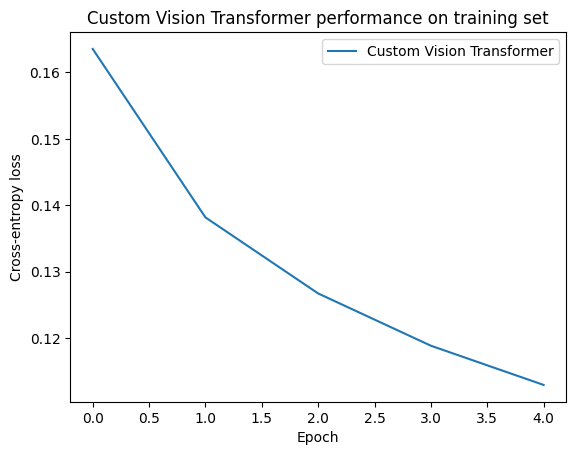

In [308]:
plt.plot(epoch_loss, label='Custom Vision Transformer')
plt.legend()
plt.title('Custom Vision Transformer performance on training set')
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.show()

## **5 Model evaluation**

#### Loading pretrained model

In [309]:
path = r'D:\DataScience\ONU\completed_labs\Pretrained_models'  # add a '\' at the end of the path
model.load_state_dict(torch.load(path+'vision_transformer'))
model = model.to(device)
model.eval()

VisionTransformer(
  (resnet): ResNet(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ResNetLayer(
        (layer): Sequential(
          (0): ResNetBlock(
            (block): Sequential(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
              (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (conv_1x1): Sequential()
          )
          (1): ResNetBlock(
            (block): Sequential(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

### 5.1 Single image prediction test

In [310]:
# get some random test images
dataiter = iter(test_loader)
test_images, test_labels = next(dataiter)

# switching to GPU
test_images = test_images.to(device)
test_labels = test_labels.to(device)

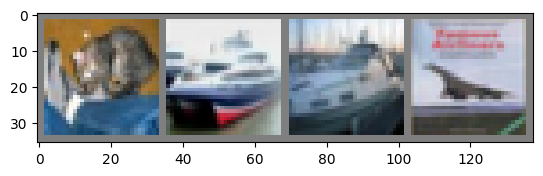

cat   ship  ship  plane


In [311]:
# starting and stopping indeces to slice 4 images
start = 0
stop = start + 4

# show images
imshow(torchvision.utils.make_grid(test_images[start:stop].cpu()))
# print labels
print(' '.join(f'{classes[test_labels[j]]:5s}' for j in range(start, stop)))

In [312]:
# Indeces of each class
for i in range(len(classes)):
    print(f'class {i} - {classes[i]}')

class 0 - plane
class 1 - car
class 2 - bird
class 3 - cat
class 4 - deer
class 5 - dog
class 6 - frog
class 7 - horse
class 8 - ship
class 9 - truck


In [313]:
def class_probabilities(predictions, classes):
    """
    Prints class probabilities sorted in descending order 
    """
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy() if predictions.get_device() != -1 else predictions.numpy()
    
    for class_probs in predictions:
        sorted_predictions = pd.DataFrame()
        sorted_predictions.index.name = 'class_index'
        sorted_predictions['class_label'] = classes
        sorted_predictions['class_probabilities'] = class_probs
        sorted_predictions = sorted_predictions.sort_values('class_probabilities', ascending=False)
        print(sorted_predictions, "\n")

#### Softmax activation

In [314]:
test_image = test_images[start+3].unsqueeze(0)

predictions = model(test_image).softmax(dim=1).cpu().detach().numpy()

predicted_class = predictions[0].argmax()
print(f'Predicted class: {predicted_class} - {classes[predicted_class]}\n')

class_probabilities(predictions, classes)

Predicted class: 0 - plane

            class_label  class_probabilities
class_index                                 
0                 plane             0.678390
9                 truck             0.248168
8                  ship             0.057427
1                   car             0.011689
2                  bird             0.002145
7                 horse             0.000997
3                   cat             0.000826
6                  frog             0.000174
4                  deer             0.000108
5                   dog             0.000077 



### 5.2 Multiple image prediction test

In [315]:
predictions = model(test_images[start:stop]).softmax(dim=1).detach()
# print(f'Class probabilities:\n{predictions}\n')

classes_np = np.array(classes)
predicted_classes = predictions.argmax(dim=1)
print(f'Predicted classes: {predicted_classes} - {classes_np[predicted_classes.cpu()]}')
print(f'True classes: {test_labels[start:stop]} - {classes_np[test_labels[start:stop].cpu()]}\n')

class_probabilities(predictions, classes)

Predicted classes: tensor([3, 8, 8, 0], device='cuda:0') - ['cat' 'ship' 'ship' 'plane']
True classes: tensor([3, 8, 8, 0], device='cuda:0') - ['cat' 'ship' 'ship' 'plane']

            class_label  class_probabilities
class_index                                 
3                   cat             0.880706
5                   dog             0.101555
6                  frog             0.009263
1                   car             0.003089
9                 truck             0.002027
8                  ship             0.000952
7                 horse             0.000883
4                  deer             0.000840
2                  bird             0.000508
0                 plane             0.000178 

            class_label  class_probabilities
class_index                                 
8                  ship         9.898782e-01
1                   car         9.041387e-03
0                 plane         1.039932e-03
9                 truck         2.728488e-05
2             

### 5.3 Prediction accuracy test

In [316]:
def accuracy_score_table(prediction_accuracy, classes):
    if isinstance(prediction_accuracy, torch.Tensor):
        if prediction_accuracy.get_device() != -1:
            prediction_accuracy = prediction_accuracy.cpu().numpy()
        else: 
            prediction_accuracy = prediction_accuracy.numpy()
    
        accuracy_table = pd.DataFrame()
        accuracy_table.index.name = 'class_index'
        accuracy_table['class_label'] = classes
        accuracy_table['prediction_accuracy'] = prediction_accuracy
        # print(accuracy_table, "\n")
        return accuracy_table
    
    print('Input is not a torch.Tensor')
    return None


In [317]:
def accuracy_score(class_probs, labels, n_classes):
    predictions = class_probs.argmax(dim=1)
    class_idx = np.arange(n_classes)
    
    accuracy = [0 for c in class_idx]
    for c in class_idx:
        accuracy[c] = ((predictions == labels) * (labels == c)).float().sum() / max((labels == c).sum(), 1)
    
    device = class_probs.get_device()
    return torch.Tensor(accuracy).to(device='cuda')

In [318]:
def evaluate(test_loader, model, n_classes=10, to_size=None, print_accuracy=False):
    """
    Calculates model's accuracy score for each batch in test_loader
    """
    # Switching model to evaluation mode
    model.eval()

    # Choosing metric
    metric = accuracy_score

    # Accuracy on the whole test set
    total_accuracy = torch.Tensor([0]*n_classes).to(device='cuda')

    n_batches = len(test_loader)
    
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            # Getting batch data
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
    
            # Class probabilities
            if to_size:
                images = torch.nn.functional.interpolate(images, (to_size, to_size))
            class_probs = model(images).softmax(dim=1).detach()
            
            # Accuracy score
            accuracy = metric(class_probs, labels, n_classes)

            if print_accuracy:
                print(accuracy_score_table(accuracy, classes))

            total_accuracy += accuracy

    total_accuracy /= n_batches
    return total_accuracy

In [319]:
total_accuracy = evaluate(test_loader, model, n_classes=10, print_accuracy=True)

            class_label  prediction_accuracy
class_index                                 
0                 plane             0.769231
1                   car             0.900000
2                  bird             0.545455
3                   cat             0.733333
4                  deer             0.700000
5                   dog             0.444444
6                  frog             0.736842
7                 horse             0.692308
8                  ship             1.000000
9                 truck             0.909091
            class_label  prediction_accuracy
class_index                                 
0                 plane             0.846154
1                   car             1.000000
2                  bird             0.692308
3                   cat             0.750000
4                  deer             0.800000
5                   dog             0.823529
6                  frog             0.900000
7                 horse             0.545455
8         

In [320]:
transformer_class_accuracy = accuracy_score_table(total_accuracy, classes)
print(transformer_class_accuracy)

            class_label  prediction_accuracy
class_index                                 
0                 plane             0.781247
1                   car             0.915119
2                  bird             0.653347
3                   cat             0.647864
4                  deer             0.674235
5                   dog             0.613997
6                  frog             0.803095
7                 horse             0.836789
8                  ship             0.857934
9                 truck             0.854257


# **ViT and ResNet20 comparison**

## Importing my pretrained ResNet20 

In [327]:
resnet20_ = ResNet(in_channels=3, num_classes=10, layer_dims=[3, 3, 3], initial_channels=16, trimmed=False)

In [328]:
path = r'D:\DataScience\ONU\completed_labs\Pretrained_models'  # add a '\' at the end of the path
state_dict = torch.load(path+'my_resnet20')
resnet20_.load_state_dict(state_dict)
resnet20_ = resnet20_.to(device)
resnet20_.eval()

ResNet(
  (fc_layer): Linear(in_features=64, out_features=10, bias=True)
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ResNetLayer(
      (layer): Sequential(
        (0): ResNetBlock(
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (conv_1x1): Sequential()
        )
        (1): ResNetBlock(
          (block): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

### Calculating mean accuracy above classes

In [329]:
total_accuracy_resnet20 = evaluate(test_loader, resnet20_, n_classes=10, print_accuracy=False)
resnet20_class_accuracy = accuracy_score_table(total_accuracy_resnet20, classes)
print(total_accuracy_resnet20)

tensor([0.7995, 0.8596, 0.4535, 0.7197, 0.8318, 0.6676, 0.8670, 0.6878, 0.8083,
        0.7617], device='cuda:0')


## Model-to-model accuracy comparison

In [330]:
resnet20_class_accuracy['model'] = 'resnet20 (custom)'
transformer_class_accuracy['model'] = 'ViT (custom)'

In [331]:
models_accuracy = pd.concat([resnet20_class_accuracy, transformer_class_accuracy])
display(models_accuracy)

,class_label,prediction_accuracy,model
class_index,,,
0,plane,0.799533,resnet20 (custom)
1,car,0.859570,resnet20 (custom)
2,bird,0.453546,resnet20 (custom)
3,cat,0.719712,resnet20 (custom)
4,deer,0.831786,resnet20 (custom)
5,dog,0.667584,resnet20 (custom)
6,frog,0.866976,resnet20 (custom)
7,horse,0.687833,resnet20 (custom)
8,ship,0.808326,resnet20 (custom)


In [332]:
sns.set(rc={'figure.figsize':(9, 5)});

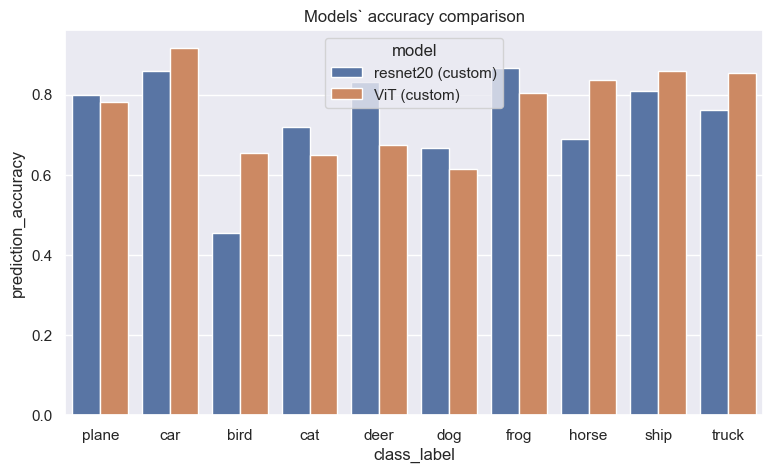

In [333]:
sns.barplot(data=models_accuracy,
            x='class_label', y='prediction_accuracy', hue='model')
plt.title('Models` accuracy comparison')
plt.show()